<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step1-train_vanilla_CNN_v2-grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Vanilla CNN to Classify Gabor Tilts
### [Vanilla CNN Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn).
--- 
## Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np

### Load and prepare the data
The dataset is comprised of 18,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range.m according to a range of 18 unique tilt/contrast combinations. 
- `tilts = [.1, .2, .4, .8, 1.6, 3.2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size was set at 32 and image size at 160 x 160. 

We will download a zip file from OSF then extract its contents and change into the newly created directory: `content/model2_training/`

In [2]:
# @title Load data

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Model 2 Training` dataset...")
name = 'model2_training'
fname = f"{name}.zip"
url = f"https://osf.io/u2pkt/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

os.chdir(name) #move into extracted folder root
print("Download completed.")

Start downloading and unzipping `Model 2 Training` dataset...
Download completed.


In [3]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'train_range')
    validation_dir = os.path.join(curr_dir, 'validation_range')
    test_dir = os.path.join(curr_dir, 'test_range')
    BATCH_SIZE = 32 
    IMG_SIZE = (160, 160)
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='grayscale') 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  color_mode='grayscale') 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  color_mode='grayscale') 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    return BATCH_SIZE,IMG_SIZE,train_dataset,validation_dataset,test_dataset,class_names

BATCH_SIZE, IMG_SIZE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

Found 11988 files belonging to 2 classes.
Found 4788 files belonging to 2 classes.
Found 1224 files belonging to 2 classes.


Confirm the images are only 1 channel (grayscale)

In [4]:
train_dataset.element_spec

(TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Verify the data
To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name above each image:

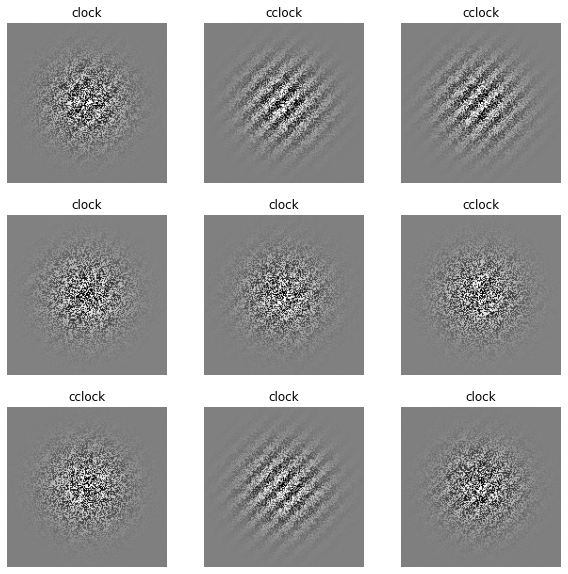

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    #plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.imshow(images[i].numpy().squeeze(axis=2).astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")
    


### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. We will standardize values to be in the `[0, 1]` range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y)) #apply normalization to dataset
image_batch, labels_batch = next(iter(normalized_ds)) #extract one batch from the norm'd dataset
first_image = image_batch[0] #view first image from the batch
image_batch2, labels_batch2 = next(iter(train_dataset)) #extract one batch from the original dataset
first_image2 = image_batch2[0] #view first image from the batch
print(f"before normalization:",np.min(first_image2),np.max(first_image2),"\n",
      f"after normalization:",np.min(first_image),np.max(first_image)) #notice the pixels values are now in `[0,1]`.

before normalization: 1.0 254.90625 
 after normalization: 0.009313726 0.9991422


Now that we are convinced the normalization works, we will include it as the first layer inside our model definition below to simplify deployment.

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [9]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

### Create the model

The first 3 lines of code below instantiate the Sequential model definition, declare the input shape of the images then apply the normalization layer.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure the CNN to process inputs of shape (160, 160, 3), which is the format of our Gabors. We can do this by passing the argument `input_shape` to the first layer titled `InputLayer`.

The next 5 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

To complete the model, we will feed the last output tensor from the convolutional base (of shape (36, 36, 320)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 2 output classes, so we use a final Dense layer with a single logit output prediction.

In [10]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(160,160,1)))
model.add(layers.experimental.preprocessing.Rescaling(1./255)) #normalization layer
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 1)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.BatchNormalization())
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(40, (3, 3), activation='relu'))
model.add(layers.Flatten()) #flatten from 3d output to 1d
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1))

Let's display the architecture of the model so far:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 158, 158, 160)     1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 80)        115280    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 40)        28840     
_________________________________________________________________
flatten (Flatten)            (None, 51840)             0

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 320). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

Finally, we see that (36, 36, 320) outputs were flattened into vectors of shape (414720) before going through two Dense layers.

### Compile and train the model

We will define the learning rate and use the BinaryCrossEntropy loss since the model provides a single linear output

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import os
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  Timestamp: 14:37:26
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%




In [13]:
base_learning_rate = 0.0001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(train_dataset, 
                    epochs=5, 
                    validation_data=validation_dataset) #tests against validation dataset after each iteration

Epoch 1/5
375/375 [==============================] - 105s 198ms/step - loss: 0.5107 - accuracy: 0.6655 - val_loss: 0.2337 - val_accuracy: 0.8960
Epoch 2/5
375/375 [==============================] - 73s 195ms/step - loss: 0.2100 - accuracy: 0.8990 - val_loss: 0.2425 - val_accuracy: 0.8630
Epoch 3/5
375/375 [==============================] - 73s 195ms/step - loss: 0.1750 - accuracy: 0.9159 - val_loss: 0.1657 - val_accuracy: 0.9282
Epoch 4/5
375/375 [==============================] - 73s 195ms/step - loss: 0.1521 - accuracy: 0.9283 - val_loss: 0.1538 - val_accuracy: 0.9236
Epoch 5/5
375/375 [==============================] - 73s 195ms/step - loss: 0.1388 - accuracy: 0.9369 - val_loss: 0.1427 - val_accuracy: 0.9350


### Evaluate the model
Let's make a plot to visualize how the training and validation accuracy improves with each epoch. We will also evaluate the model against the test dataset.

39/39 - 3s - loss: 0.1419 - accuracy: 0.9379


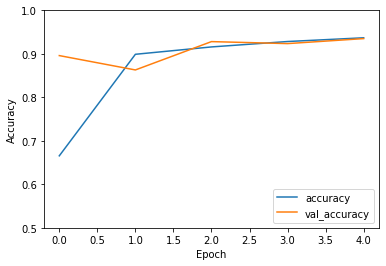

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

Nicely done! The model achieved a 93.5% accuracy on the validation set and a 93.79% accuracy on the test set after 5 epochs. Now let's save our vanilla CNN model.

In [15]:
model.save('18kim_range_vanilla')

INFO:tensorflow:Assets written to: 18kim_range_vanilla/assets


In [16]:
! zip -r vanilla_model.zip /content/model2_training/18kim_range_vanilla/

  adding: content/model2_training/18kim_range_vanilla/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/saved_model.pb (deflated 88%)
  adding: content/model2_training/18kim_range_vanilla/variables/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/variables/variables.index (deflated 66%)
  adding: content/model2_training/18kim_range_vanilla/variables/variables.data-00000-of-00001 (deflated 46%)
  adding: content/model2_training/18kim_range_vanilla/assets/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/keras_metadata.pb (deflated 91%)
